# 로지스틱 회귀분석

In [1]:
# 분석에 필요한 패키지 불러오기
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time

In [2]:
'''
Experience 경력
Income 수입
Famliy 가족단위
CCAvg 월 카드사용량 
Education 교육수준 (1: undergrad; 2, Graduate; 3; Advance )
Mortgage 가계대출
Securities account 유가증권계좌유무
CD account 양도예금증서 계좌 유무
Online 온라인계좌유무
CreidtCard 신용카드유무 
'''

ploan = pd.read_csv("./data/Personal_Loan.csv")
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# 의미없는 변수 제거
ploan_processed = ploan.dropna().drop(['ID','ZIP Code'], axis=1, inplace=False)

In [4]:
ploan_processed = sm.add_constant(ploan_processed, has_constant='add')
ploan_processed.head()

,const,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1.0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,1.0,45,19,34,3,1.5,1,0,0,1,0,0,0
2,1.0,39,15,11,1,1.0,1,0,0,0,0,0,0
3,1.0,35,9,100,1,2.7,2,0,0,0,0,0,0
4,1.0,35,8,45,4,1.0,2,0,0,0,0,0,1


# 설명변수(X), 타켓변수(Y) 분리 및 학습데이터와 평가데이터

In [5]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))

X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan']    # 대출여부: 1 or 0

In [6]:
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 12) (750, 12) (1750,) (750,)


# 로지스틱회귀모형 모델링 y = f(x)

In [7]:
model = sm.Logit(train_y, train_x).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.131055
         Iterations 9


In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 1750
Model:                          Logit   Df Residuals:                     1738
Method:                           MLE   Df Model:                           11
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                  0.6030
Time:                        18:29:20   Log-Likelihood:                -229.35
converged:                       True   LL-Null:                       -577.63
Covariance Type:            nonrobust   LLR p-value:                2.927e-142
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                    0.0245      0.102      0.240      0.810      -0.175       0.224
CCAvg                  0.0985      0.063      1.562      0.118      -0.025       0.222
CD Account             4.3726      0.568      7.703      0.000       3.260       5.485
CreditCard            -1.2374      0.337     -3.667      0.000      -1.899      -0.576
Education              1.5203      0.190      7.999      0.000       1.148       1.893
Experience            -0.0070      0.102     -0.069      0.945      -0.206       0.192
Family                 0.7579      0.128      5.914      0.000       0.507       1.009
Income                 0.0547      0.004     12.659      0.000       0.046       0.063
Mortgage              -0.0001      0.001     -0.144      0.885      -0.002       0.002
Online                -0.4407      0.263     -1.674      0.094      -0.957       0.075
Securities Account    -1.8520      0.561     -3.299      0.001      -2.952      -0.752
const                -13.9203      2.773     -5.021      0.000     -19.354      -8.486
======================================================================================
"""

In [9]:
# performance measure
print("model AIC: ","{:.5f}".format(model.aic))

model AIC:  482.69329


In [10]:
np.exp(model.params)

## 나이가 한살 많을수록 대출할 확률이 1.024 높다.
## 수입이 1단위 높을수룩 대출할 확률이 1.05배 높다 
## 가족 구성원수가 1 많을수록 대출할 확률이 2.13배 높다

## Experience, Mortgage는 제외할 필요성이 있음. (p-value)

Age                   1.024773e+00
CCAvg                 1.103479e+00
CD Account            7.924761e+01
CreditCard            2.901239e-01
Education             4.573729e+00
Experience            9.929928e-01
Family                2.133814e+00
Income                1.056218e+00
Mortgage              9.998665e-01
Online                6.435563e-01
Securities Account    1.569221e-01
const                 9.005163e-07
dtype: float64

In [11]:
pred_y = model.predict(test_x)

In [12]:
def cut_off(y, threshold):
    Y = y.copy()       # copy함수를 사용하여 이전의 y값이 변화지 않게 함
    Y[Y>threshold]  = 1
    Y[Y<=threshold] = 0
    return(Y.astype(int))

pred_Y = cut_off(pred_y, 0.5)
pred_Y.head()

1065    0
487     0
2157    0
1765    0
525     0
dtype: int32

In [13]:
cfmat = confusion_matrix(test_y, pred_Y)
print(cfmat)

[[661  12]
 [ 28  49]]


In [14]:
## accuracy
(cfmat[0,0]+cfmat[1,1])/np.sum(cfmat) 

0.9466666666666667

## 임계값(cut-off)에 따른 성능지표 비교


In [15]:
## accuracy function
def acc(cfmat) :
    acc=(cfmat[0,0]+cfmat[1,1])/np.sum(cfmat) 
    return(acc)

In [16]:
threshold = np.arange(0, 1, 0.1)

table = pd.DataFrame(columns=['ACC'])

for i in threshold:
    pred_Y = cut_off(pred_y, i)
    cfmat = confusion_matrix(test_y, pred_Y)
    table.loc[i] = acc(cfmat)

table.index.name='threshold'
table.columns.name='performance'
table

performance,ACC
threshold,
0.0,0.102667
0.1,0.908000
0.2,0.922667
0.3,0.933333
0.4,0.934667
0.5,0.946667
0.6,0.949333
0.7,0.946667
0.8,0.941333


AUC: 0.9463923891858513


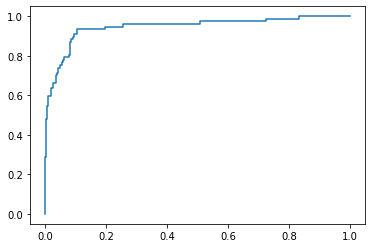

In [17]:
# sklearn ROC 패키지
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)

# Print ROC curve
plt.plot(fpr,tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

### Experience,  Mortgage 제거

In [18]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan", "Experience",  "Mortgage"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] # 대출여부: 1 or 0

In [19]:
train_x2, test_x2, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.3,random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 12) (750, 12) (1750,) (750,)


In [20]:
model_2 = sm.Logit(train_y, train_x2).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.131062
         Iterations 9


In [21]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 1750
Model:                          Logit   Df Residuals:                     1740
Method:                           MLE   Df Model:                            9
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                  0.6029
Time:                        18:29:20   Log-Likelihood:                -229.36
converged:                       True   LL-Null:                       -577.63
Covariance Type:            nonrobust   LLR p-value:                3.817e-144
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                    0.0174      0.011      1.569      0.117      -0.004       0.039
CCAvg                  0.0997      0.062      1.596      0.111      -0.023       0.222
CD Account             4.3699      0.567      7.705      0.000       3.258       5.481
CreditCard            -1.2350      0.337     -3.668      0.000      -1.895      -0.575
Education              1.5249      0.187      8.156      0.000       1.158       1.891
Family                 0.7572      0.127      5.948      0.000       0.508       1.007
Income                 0.0546      0.004     12.833      0.000       0.046       0.063
Online                -0.4418      0.263     -1.678      0.093      -0.958       0.074
Securities Account    -1.8526      0.561     -3.302      0.001      -2.952      -0.753
const                -13.7465      1.164    -11.814      0.000     -16.027     -11.466
======================================================================================
"""

In [22]:
pred_y = model_2.predict(test_x2)

pred_Y = cut_off(pred_y,0.5)
pred_Y.head()

1065    0
487     0
2157    0
1765    0
525     0
dtype: int32

In [23]:
cfmat = confusion_matrix(test_y, pred_Y)
print(cfmat)

[[660  13]
 [ 29  48]]


In [24]:
acc(cfmat)   ## accuracy

0.944

In [25]:
threshold = np.arange(0, 1, 0.1)

table = pd.DataFrame(columns=['ACC'])

for i in threshold:
    pred_Y = cut_off(pred_y, i)
    cfmat = confusion_matrix(test_y, pred_Y)
    table.loc[i] = acc(cfmat)

table.index.name='threshold'
table.columns.name='performance'
table

performance,ACC
threshold,
0.0,0.102667
0.1,0.908000
0.2,0.922667
0.3,0.932000
0.4,0.936000
0.5,0.944000
0.6,0.949333
0.7,0.946667
0.8,0.941333


AUC: 0.9465467667547905


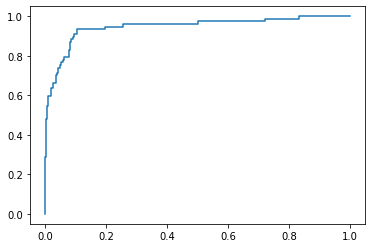

In [26]:
# sklearn ROC 패키지 제공
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)

# Print ROC curve
plt.plot(fpr,tpr)

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

# 변수선택법

In [27]:
feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] # 대출여부: 1 or 0

In [28]:
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 12) (750, 12) (1750,) (750,)


In [29]:
def processSubset(X, y, feature_set):
    regr = sm.Logit(y, X[list(feature_set)]).fit()
    AIC = regr.aic
    return {"model":regr, "AIC":AIC}
        
'''
전진선택법
'''
def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [ k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return(Fmodels['model'][len(Fmodels['model'])])


'''
후진소거법
'''
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model


def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Bmodels['model'].dropna().iloc[0])


'''
단계적 선택법
'''
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [30]:
Forward_best_model = forward_model(X=train_x, y= train_y)

Optimization terminated successfully.
         Current function value: 0.329986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.284217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.205738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.324953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329912
  

In [31]:
Backward_best_model = backward_model(X=train_x,y=train_y)

Optimization terminated successfully.
         Current function value: 0.137663
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131859
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131061
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.214795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.142500
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131057
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.154241
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.135440
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152443
  

In [32]:
Stepwise_best_model = Stepwise_model(X=train_x,y=train_y)

Optimization terminated successfully.
         Current function value: 0.330076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.284217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.205738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.324953
  

Optimization terminated successfully.
         Current function value: 0.132361
         Iterations 9
Processed  5 models on 7 predictors in 0.0219423770904541
Selected predictors: ['Income', 'Education', 'CD Account', 'Family', 'CreditCard', 'Securities Account', 'Online', 'const']  AIC: <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000026A79249148>
forward
Optimization terminated successfully.
         Current function value: 0.133263
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.135928
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136688
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143335
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.154141
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.156593
         Iterations 9
Op

In [33]:
pred_y_full = model_2.predict(test_x2) # full model

pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_x[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])

In [34]:
pred_Y_full= cut_off(pred_y_full,0.5)
pred_Y_forward = cut_off(pred_y_forward,0.5)
pred_Y_backward = cut_off(pred_y_backward,0.5)
pred_Y_stepwise = cut_off(pred_y_stepwise,0.5)

In [35]:
cfmat_full = confusion_matrix(test_y, pred_Y_full)
cfmat_forward = confusion_matrix(test_y, pred_Y_forward)
cfmat_backward = confusion_matrix(test_y, pred_Y_backward)
cfmat_stepwise = confusion_matrix(test_y, pred_Y_stepwise)

In [36]:
print(acc(cfmat_full))
print(acc(cfmat_forward))
print(acc(cfmat_backward))
print(acc(cfmat_stepwise))

0.944
0.944
0.944
0.944


AUC: 0.9465467667547905


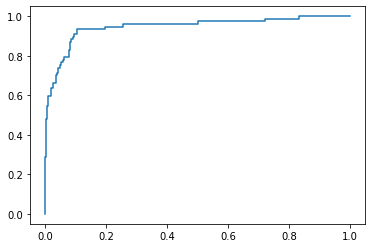

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_full, pos_label=1)
# Print ROC curve
plt.plot(fpr,tpr)
# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.9465467667547905


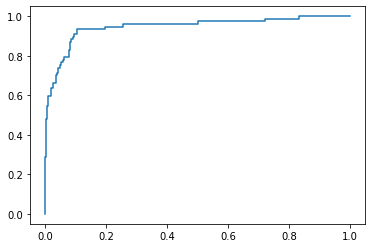

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_forward, pos_label=1)
# Print ROC curve
plt.plot(fpr,tpr)
# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.9465467667547905


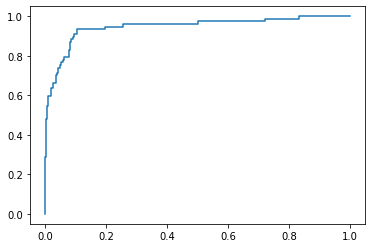

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_backward, pos_label=1)
# Print ROC curve
plt.plot(fpr,tpr)
# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.9465467667547905


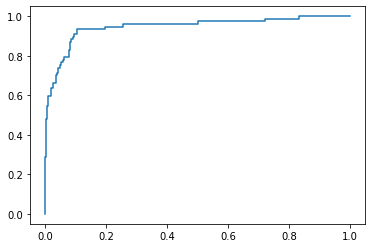

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_stepwise, pos_label=1)
# Print ROC curve
plt.plot(fpr,tpr)
# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [41]:
###성능면에서는 네 모델이 큰 차이가 없음
print(len(Forward_best_model.model.exog_names))
print(len(Backward_best_model.model.exog_names))
print(len(Stepwise_best_model.model.exog_names))

10
10
10
